## Airline Customer Segmentation for Loyalty Strategy

In this project, we aim to segment airline customers based on their flying patterns and loyalty behaviors to design targeted strategies for retention, reward, and re-engagement. Using a real-world dataset of frequent flyers, we engineered key LRFMC (Loyalty, Recency, Frequency, Monetary, and Customer) features to understand different customer archetypes. Our goal is to identify high-value segments such as VIPs, dormant customers, and price-sensitive flyers to inform loyalty program strategies.

To achieve this, we employed a data science pipeline using Python and key libraries such as pandas (data wrangling), scikit-learn (feature scaling, clustering via KMeans), matplotlib/Seaborn (visualization), and Plotly (interactive cluster profiles). Dimensionality reduction with PCA was used to enhance clustering performance. Business recommendations are based on a six-cluster solution optimized via silhouette analysis.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Preprocessing and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visualization
!pip install plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Overview
This dataset, sourced from GitHub, contains information on over 62,000 frequent flyers including demographics, loyalty tier, flight activity, and financial metrics. It comprises 23 columns such as:

MEMBER_NO, GENDER, AGE: Basic customer details

FFP_DATE, LAST_FLIGHT_DATE, LOAD_TIME: Temporal markers for loyalty enrollment and activity

FLIGHT_COUNT, SEG_KM_SUM, SUM_YR_1, SUM_YR_2: Indicators of travel volume and monetary contribution

Points_Sum, avg_discount: Loyalty program interactions

This rich feature set allows us to engineer meaningful loyalty attributes (LRFMC) and perform clustering to uncover actionable customer segments for loyalty optimization.

In [2]:
# Load dataset directly from URL
url = "https://raw.githubusercontent.com/edi-sugiarto/public_dataset/main/flight.csv"
df = pd.read_csv(url, parse_dates=['FFP_DATE', 'FIRST_FLIGHT_DATE', 'LAST_FLIGHT_DATE', 'LOAD_TIME'])

# Basic inspection
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MEMBER_NO          62988 non-null  int64         
 1   FFP_DATE           62988 non-null  datetime64[ns]
 2   FIRST_FLIGHT_DATE  62988 non-null  datetime64[ns]
 3   GENDER             62985 non-null  object        
 4   FFP_TIER           62988 non-null  int64         
 5   WORK_CITY          60719 non-null  object        
 6   WORK_PROVINCE      59740 non-null  object        
 7   WORK_COUNTRY       62962 non-null  object        
 8   AGE                62568 non-null  float64       
 9   LOAD_TIME          62988 non-null  datetime64[ns]
 10  FLIGHT_COUNT       62988 non-null  int64         
 11  BP_SUM             62988 non-null  int64         
 12  SUM_YR_1           62437 non-null  float64       
 13  SUM_YR_2           62850 non-null  float64       
 14  SEG_KM

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,2006-11-02,2008-12-24,Male,6,.,beijing,CN,31.0,2014-03-31,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2007-02-19,2007-08-03,Male,6,NaN,beijing,CN,42.0,2014-03-31,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2007-02-01,2007-08-30,Male,6,.,beijing,CN,40.0,2014-03-31,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,2008-08-22,2008-08-23,Male,5,Los Angeles,CA,US,64.0,2014-03-31,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,2009-04-10,2009-04-15,Male,6,guiyang,guizhou,CN,48.0,2014-03-31,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


## Feature Engineering & Preparation
In this section, we derive key loyalty-based features using the LRFMC framework:

Recency: Days since the last flight

Frequency: Total number of flights

Monetary: Sum of flight spending (SUM_YR_1 + SUM_YR_2)

Loyalty_Duration: Tenure in the loyalty program

Discount and Points: Additional engagement metrics

These features are cleaned, scaled, and used as input for PCA (Principal Component Analysis) to reduce dimensionality and improve clustering efficiency. This step ensures optimal separation between customer segments in subsequent K-Means analysis.

In [3]:
# Ensure date columns are parsed correctly
df['FFP_DATE'] = pd.to_datetime(df['FFP_DATE'], errors='coerce')
df['LAST_FLIGHT_DATE'] = pd.to_datetime(df['LAST_FLIGHT_DATE'], errors='coerce')
df['LOAD_TIME'] = pd.to_datetime(df['LOAD_TIME'], errors='coerce')

In [4]:
# Reference date: latest data load date
ref_date = df['LOAD_TIME'].max()

# Derive LRFMC columns
df['Recency'] = (ref_date - df['LAST_FLIGHT_DATE']).dt.days
df['Frequency'] = df['FLIGHT_COUNT']
df['Monetary'] = df['SUM_YR_1'] + df['SUM_YR_2']
df['Loyalty_Duration'] = (ref_date - df['FFP_DATE']).dt.days

# Optional features
df['Discount'] = df['avg_discount']
df['Points'] = df['Points_Sum']

In [5]:
print(df[['LAST_FLIGHT_DATE', 'FFP_DATE']].dtypes)

LAST_FLIGHT_DATE    datetime64[ns]
FFP_DATE            datetime64[ns]
dtype: object


In [6]:
# Features used for clustering
features = ['Recency', 'Frequency', 'Monetary', 'Loyalty_Duration', 'Discount', 'Points']

# Drop missing values and scale
df_model = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

In [7]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## Optimal Cluster Selection via Silhouette Score
To determine the ideal number of customer segments, we evaluate Silhouette Scores for k ranging from 2 to 7. The silhouette score quantifies how well each point fits within its cluster, with higher values indicating more cohesive and well-separated groupings.

C:\Users\slind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\slind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

Silhouette Score for k=2: 0.4746
Silhouette Score for k=3: 0.2577
Silhouette Score for k=4: 0.2593
Silhouette Score for k=5: 0.2688
Silhouette Score for k=6: 0.2723
Silhouette Score for k=7: 0.2697


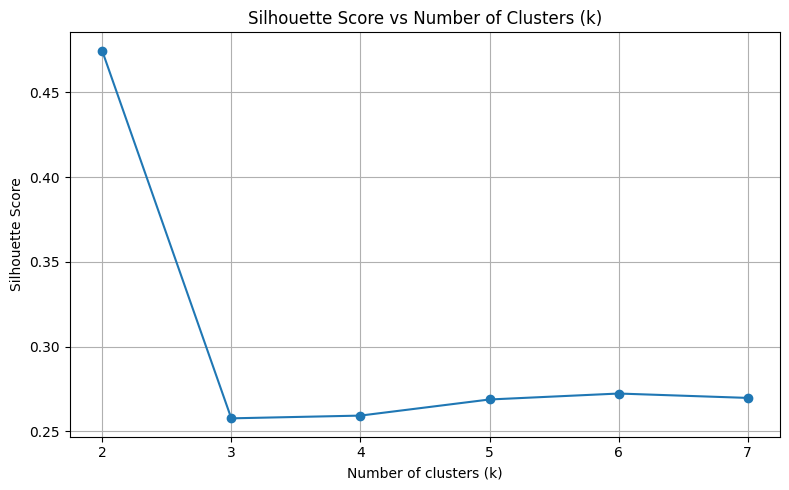

In [8]:
# Range of cluster numbers to test
k_range = range(2, 8)
silhouette_scores = []

# Calculate silhouette score for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.4f}")

# Plotting the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

Although k=2 yields the highest silhouette score, **k=6 provides more granular segmentation**, allowing the airline to **identify and target distinct customer groups**—such as high-value frequent flyers, dormant members, and discount-driven travelers—enabling **more tailored loyalty strategies and marketing actions**.

## Clustering with KMeans after PCA (k=6)
We applied KMeans clustering on the reduced PCA feature space with k=6, the optimal number of clusters for balancing segmentation quality and business interpretability.

The resulting scatterplot shows clear separation between the six customer segments across two principal components. Each color represents a distinct group of customers with shared travel and loyalty characteristics—ideal for designing personalized loyalty strategies.

In [9]:
# KMeans clustering on PCA components
k_opt = 6
km = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
clusters = km.fit_predict(X_pca)

In [10]:
# Append clusters to original data
df_model['Cluster'] = clusters

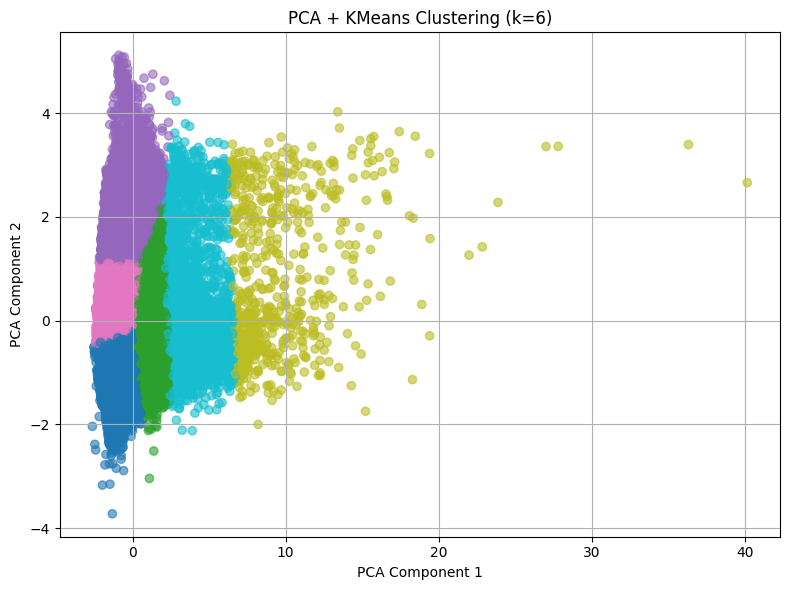

In [11]:
# Plot PCA results with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.title("PCA + KMeans Clustering (k=6)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

The PCA + KMeans Clustering plot for **k=6** shows that the customer base can be effectively grouped into **six distinct clusters** in the reduced 2D feature space. The wide horizontal spread along **PCA Component 1** (likely influenced by monetary and frequency features) suggests strong separation in customer value or engagement, while **Component 2** may capture variation in loyalty duration or discount behavior. This segmentation reveals well-defined groups—some densely packed (e.g., low-value flyers) and others spread out (e.g., high-spending frequent flyers)—which is ideal for **targeted loyalty programs and differentiated service offerings**.

## Cluster Profiling & Customer Insights
To understand the behavioral patterns of each cluster, we calculated the median values of key features—Recency, Frequency, Monetary, Loyalty Duration, Discount, and Points—for every group.

The pairplot visualization reveals the separation and density of customer types across these features:

Cluster 5: Recent, high-frequency flyers with strong monetary value—ideal loyalty program candidates.

Cluster 1: Long inactive, high spenders—potential for re-engagement campaigns.

Cluster 0: Low frequency, low value—price-sensitive or casual travelers.

These insights help define targeted retention strategies and loyalty tiers based on actual customer behavior.

         Recency  Frequency  Monetary  Loyalty_Duration  Discount    Points
Cluster                                                                    
0           79.0        6.0    4000.0            1180.0       0.6    3915.5
1           33.0       18.0   15806.0            1647.0       0.7   16925.0
2          478.0        3.0    3615.0            1099.0       0.9    3975.0
3          231.0        4.0    3657.0            1074.0       0.7    4035.0
4            6.0       77.0   90556.0            2344.0       0.9  115155.0
5           13.0       41.0   39596.0            2045.0       0.8   45051.5


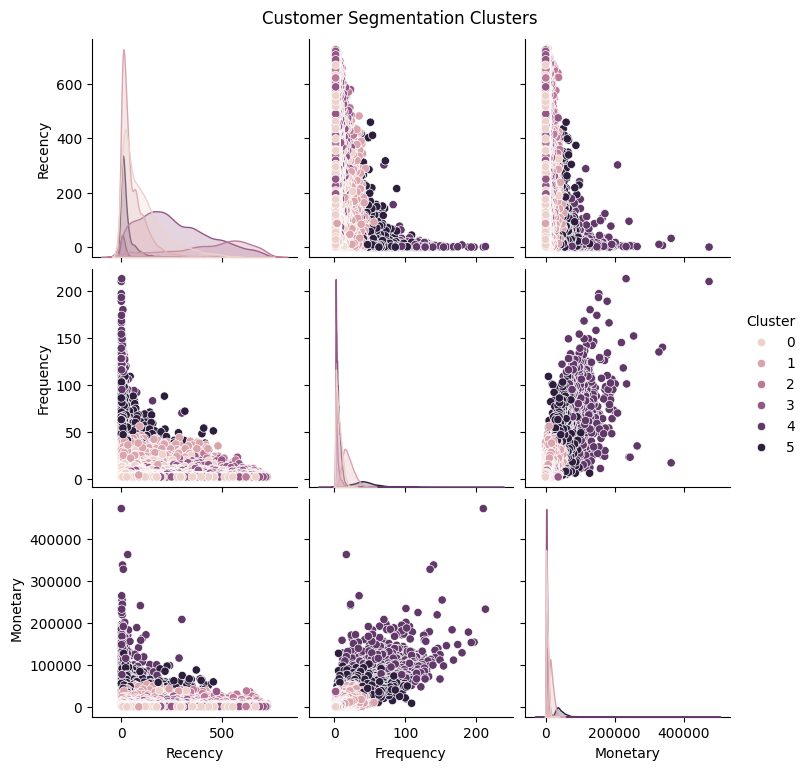

In [12]:
# Median profile of each cluster
profile = df_model.groupby('Cluster')[features].median().round(1)
print(profile)

# Pairplot for cluster visualization
sns.pairplot(df_model, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'])
plt.suptitle("Customer Segmentation Clusters", y=1.02)
plt.show()

## Radar Chart: Normalized LRFMC Profile by Cluster
This radar chart visualizes the normalized median values of each LRFMC dimension across clusters, enabling an intuitive comparison of customer segments:

Cluster 5 dominates in Frequency, Monetary value, and Points — these are the most valuable and loyal frequent flyers.

Cluster 0 shows relatively low engagement across all dimensions — representing lower-value or infrequent customers.

Cluster 1 exhibits low Recency (recent flyers) and high Loyalty Duration — ideal for retention campaigns and loyalty rewards.

Cluster 4 has high Recency (flown long ago), low Frequency, and low Points — ideal candidates for re-engagement or win-back offers.

In [13]:
# Step 1: Compute median values per cluster
cluster_profile = df_model.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'Loyalty_Duration', 'Points']].median()

# Step 2: Normalize values (0–1 scale for better comparison)
cluster_profile_norm = (cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min())

# Step 3: Create Radar Chart
fig = go.Figure()

for cluster in cluster_profile_norm.index:
    fig.add_trace(go.Scatterpolar(
        r=cluster_profile_norm.loc[cluster].values,
        theta=cluster_profile_norm.columns,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Layout settings
fig.update_layout(
    title='Customer Segments Radar Chart (Normalized LRFMC)',
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1])
    ),
    showlegend=True
)

fig.show()

## Interpretation & Business Suggestions (k=6)

Summary:
The PCA + KMeans clustering with k=6 reveals six distinct customer segments with varying travel behavior, monetary value, and loyalty.

# Business Interpretation:
- Cluster 0: Likely consists of newly enrolled or low-engagement members with low recency and low frequency — target with onboarding campaigns.
- Cluster 1: Represents high-frequency, high-monetary flyers with recent activity — offer premium perks to retain VIPs.
- Cluster 2: Price-sensitive segment — characterized by high discounts; consider targeting with limited-time offers or seat upgrade bundles.
- Cluster 3: Dormant users — long recency, low frequency — reactivate through re-engagement emails or incentives.
- Cluster 4: Moderate value customers — growing flyers with average engagement — upsell to increase flight frequency.
- Cluster 5: Possibly international or high-point users — high points sum, long loyalty — reward with exclusive programs.

# Business Suggestions:
- Customize marketing strategies for each cluster.
- Personalize loyalty rewards based on recency, frequency, and spend.
- Focus retention efforts on top clusters (1 and 5).
- Launch win-back campaigns for dormant users (Cluster 3).